# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Set-up environment

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["text"]

And the corresponding image

In [ ]:
dataset[0]["image"]

## Custom Dataset

In [ ]:
%%writefile custom_dataset.py
from datasets import GeneratorBasedBuilder, DatasetInfo, SplitGenerator, Features, Value, Sequence
from PIL import Image
import os
import csv

BASE_PATH = '/content/drive/MyDrive/OA/EdLight/Task1/'
DATA_PATH = BASE_PATH + 'data/'
IMAGE_PATH = DATA_PATH + 'images/'
ANNOT_FILE = DATA_PATH + 'descriptions.csv'


class CustomImageCaptioningDataset(GeneratorBasedBuilder):
    """
    Custom Image Captioning Dataset.
    """

    def _info(self) -> DatasetInfo:
        """
        Specifies the datasets.DatasetInfo object.
        """
        return DatasetInfo(
            features=Features({
                'image': Value('object'),  # For image data, 'object' type is used
                'caption': Value('string')  # For caption text, 'string' type is used
            }),
            supervised_keys=None,
        )

    def _split_generators(self, dl_manager):
        """
        Specifies SplitGenerators.
        """
        # Here you could download data, but in our case, data is local, so we'll simply return the path
        return [
            SplitGenerator(name='train',
                           gen_kwargs={'directory': IMAGE_PATH,
                                       'annotation_file': ANNOT_FILE})
        ]

    def _generate_examples(self, directory, annotation_file):
        """
        Yields examples.
        """
        # Read the annotations from the CSV file
        annotations = {}
        with open(annotation_file, 'r') as csvfile:
            csvreader = csv.reader(csvfile)
            for row in csvreader:
                image_file, caption = row[0], row[1]
                annotations[image_file] = caption

        # Loop through the images in the directory
        for image_file in os.listdir(directory):
            if image_file in annotations:
                # Open image using PIL
                image_path = os.path.join(directory, image_file)
                with open(image_path, 'rb') as f:
                    image = Image.open(f)
                    image = image.convert('RGB')

                # Get the corresponding caption
                caption = annotations[image_file]

                yield image_file, {
                    'image': image,
                    'text': caption,
                }


In [ ]:
!ls

In [ ]:
from datasets import load_dataset
from custom_dataset import *

# Load custom dataset
dataset = load_dataset(path='custom_dataset.py')

# Access an example
print(dataset['train'][0])

In [ ]:
dataset[0]["text"]

In [ ]:
dataset[0]["image"]

## Dataset


In [2]:
!pip install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/7c/55/b3432f43d6d7fee999bb23a547820d74c48ec540f5f7842e41aa5d8d5f3a/datasets-2.14.6-py3-none-any.whl.metadata
  Using cached datasets-2.14.6-py3-none-any.whl.metadata (19 kB)
  Obtaining dependency information for pyarrow>=8.0.0 from https://files.pythonhosted.org/packages/f6/c8/ad19a273d6e825fcd040f51b559d30f55d652d82f5badf1f546a9a06aeb9/pyarrow-13.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached pyarrow-13.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (3.0 kB)
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Using cached dill-0.3.7-py3-none-any.whl.metadata (9.9 kB)
  Obtaining dependency information for tqdm>=4.62.1 from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83

In [4]:
from datasets import load_dataset

BASE_PATH = ''
DATA_PATH = BASE_PATH + 'data/'
# IMAGE_PATH = DATA_PATH + 'images/'
# ANNOT_FILE = DATA_PATH + 'descriptions.csv'

dataset = load_dataset("imagefolder",
                       data_dir=DATA_PATH,
                       split="train")


Resolving data files: 100%|██████████| 4516/4516 [00:00<00:00, 1031502.31it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 4516 examples [00:00, 7012.93 examples/s]


In [5]:
dataset[0]["text"]

'table drawn with two rows: flour and vanilla. First row is 5 and 2. second row is 50 and 20. \\times10 written next to an arrow from the first row to the second row on both columns.'

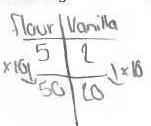

In [6]:
dataset[0]["image"]

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"],
                                  padding="max_length",
                                  return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

Next we define our `LoraConfig` object. We explicitly tell

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(200):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

## Inference

Let's check the results on our train dataset

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

## Push to Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("ybelkada/blip2-opt-2.7b-football-captions-adapters")

## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!
Please restart the runtime to run the cell below!

In [ ]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "ybelkada/blip2-opt-2.7b-football-captions-adapters"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

Let's check the results on our train dataset!

In [ ]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")